In [14]:
# ===== REQUIRED IMPORTS (RUN FIRST) =====
import os
import cv2
import h5py
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit


In [15]:
import cv2
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to your .mat file
path = "C:/Users/Tanishqa More/OneDrive/Documents/quantum_image_representation/datasets/brain_tumor/2299.mat"

# Open the MAT file
with h5py.File(path, 'r') as f:
    print("Keys in file:", list(f.keys()))   # Check keys
    img = np.array(f['cjdata']['image'])    # Adjust key based on output

# If 3D MRI volume, pick middle slice
if img.ndim == 3:
    img = img[:, :, img.shape[2] // 2]

# Normalize to 0-1im
img = (img - img.min()) / (img.max() - img.min())


Keys in file: ['cjdata']


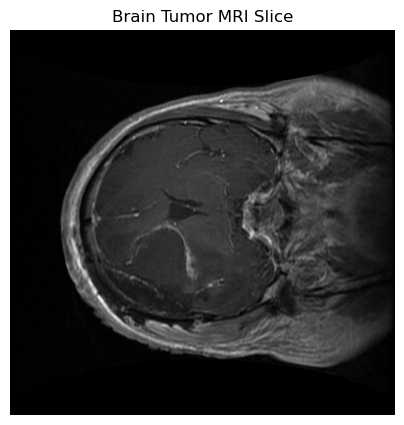

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.title("Brain Tumor MRI Slice")
plt.axis('off')  # Remove axes for clean view
plt.show()

In [17]:
def load_image(path, size=8):
    if not os.path.exists(path):
        raise FileNotFoundError(f" File not found: {path}")

    ext = os.path.splitext(path)[1].lower()
    img = None

    if ext in [".png", ".jpg", ".jpeg"]:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(" Unable to read image file")
    elif ext == ".mat":
        try:
            with h5py.File(path, 'r') as f:
                if 'cjdata' in f and 'image' in f['cjdata']:
                    img = np.array(f['cjdata']['image'])
                else:
                    for key in f.keys():
                        if isinstance(f[key], h5py.Dataset):
                            img = np.array(f[key])
                            break
            if img is None:
                raise ValueError(" No valid dataset found in MAT file")
        except OSError:
            import scipy.io
            mat = scipy.io.loadmat(path)
            for key in mat:
                if isinstance(mat[key], np.ndarray) and mat[key].ndim >= 2:
                    img = mat[key]
                    break
        if img.ndim == 3:
            img = img[:, :, img.shape[2] // 2]  # middle slice
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
    else:
        raise ValueError(" Unsupported file format")

    img = cv2.resize(img, (size, size))
    return img

In [18]:
def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 1)
    qc.h(range(n))
    for i, p in enumerate(pixels):
        qc.ry(p * math.pi, n)
    return qc

In [19]:
def neqr_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 8)
    qc.h(range(n))
    for p in pixels:
        value = int(p * 255)
        binary = format(value, "08b")
        for i, bit in enumerate(binary):
            if bit == "1":
                qc.x(n + i)
    return qc


In [20]:
def mcqi_encode(image):
    if image.ndim != 3 or image.shape[2] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    pixels = image.flatten()
    n = int(np.log2(len(pixels)//3))
    qc = QuantumCircuit(n + 1)
    qc.h(range(n))
    for i, p in enumerate(pixels):
        qc.ry(p * (math.pi/3), n)
    return qc

In [21]:
def ql_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n)
    for i, p in enumerate(pixels):
        if p > 0.5:
            qc.x(i)
    return qc

In [22]:
def qpie_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n)
    qc.h(range(n))
    for i, p in enumerate(pixels):
        qc.ry(p*math.pi/2, i)
    return qc

In [23]:
def evaluate(circuit, model_type):
    qubits = circuit.num_qubits
    depth = circuit.depth()
    gates = sum(circuit.count_ops().values())
    gate_fidelity = round(1 / (gates + 1), 6)
    encoding_time = round(depth * 0.0001, 6)

    if model_type in ["FRQI", "MCQI", "QPIE"]:
        data_loss = "Yes"
        reconstruction = "Medium"
        transform_support = "High"
        scalability = "High"
        noise_robustness = "Medium"
    else:
        data_loss = "No"
        reconstruction = "High"
        transform_support = "Moderate"
        scalability = "Low"
        noise_robustness = "Low"

    return {
        "Qubit Count": qubits,
        "Gate Count": gates,
        "Circuit Depth": depth,
        "Gate Fidelity": gate_fidelity,
        "Data Loss": data_loss,
        "Encoding Time (s)": encoding_time,
        "Reconstruction Accuracy": reconstruction,
        "Transformation Supportability": transform_support,
        "Scalability": scalability,
        "Noise Robustness": noise_robustness
    }

In [24]:
base_dir = r"C:\Users\Tanishqa More\OneDrive\Documents\quantum_image_representation\datasets"

datasets = {}
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
             if f.endswith(('.mat', '.png', '.jpg', '.jpeg'))]
    datasets[folder] = files[:2] 

In [25]:
#techniques = {
   # "FRQI": frqi_encode,
   # "NEQR": neqr_encode,
   # "MCQI": mcqi_encode,
   # "QL": ql_encode,
    #"QPIE": qpie_encode
#}


In [26]:
techniques = {
    "FRQI": frqi_encode,
    "NEQR": neqr_encode,
    "MCQI": mcqi_encode,
    "QL": ql_encode,
    "QPIE": qpie_encode
}



Dataset: brain_tumor


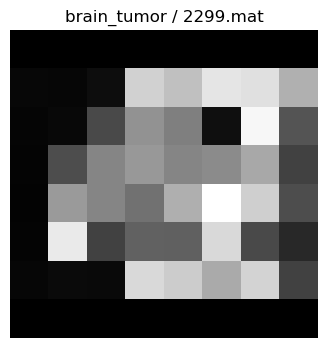


FRQI Quantum Circuit:


┌───┐                                                                 »
q_0: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_1: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_2: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_3: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_4: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_5: ──┤ H ├─────────────────────────────────────────────────────────────────»
     ┌─┴───┴─┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                   »
«q_0: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_1: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_3: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_4: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_5: ──────────────────────────────────────────────────────────────»
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌────────────┐»
«q_6: ┤ Ry(0.037223) ├┤ Ry(0.033638) ├┤ Ry(0.065071) ├┤ Ry(1.0262) ├»
«     └──────────────┘└──────────────┘└──────────────┘└────────────┘»
«                                                               »
«q_0: ──────────────────────────────────────────────────────────»
«                                                               »
«q_1: ──────────────────────────────────────────────────────────»
«                                                               »
«q_2: ──────────────────────────────────────────────────────────»
«                                                               »
«q_3: ──────────────────────────────────────────────────────────»
«                                                               »
«q_4: ──────────────────────────────────────────────────────────»
«                                                               »
«q_5: ──────────────────────────────────────────────────────────»
«     ┌─────────────┐┌────────────┐┌────────────┐┌─────────────┐»
«q_6: ┤ Ry(0.93967) ├┤ Ry(1.1212) ├┤ Ry(1.0988) ├┤ Ry(0.86219) ├»
«     └─────────────┘└────────────┘└────────────┘└─────────────┘»
«                                                                   »
«q_0: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_1: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_3: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_4: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_5: ──────


FRQI Evaluation:
Qubit Count: 7
Gate Count: 70
Circuit Depth: 64
Gate Fidelity: 0.014085
Data Loss: Yes
Encoding Time (s): 0.0064
Reconstruction Accuracy: Medium
Transformation Supportability: High
Scalability: High
Noise Robustness: Medium
Encoding Time (computed): 0.001587s

NEQR Quantum Circuit:


┌───┐                                                                 »
 q_0: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_1: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_2: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_3: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_4: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
      └───┘                                                                 »
 q_6: ──────────────────────────────────────────────────────────────────────»
      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
 q_7: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
 q_8: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
 q_9: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_10: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_11: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_12: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_13: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                  
« q_0: ────────────────────────────────────────────────────────────
«                                                                  
« q_1: ────────────────────────────────────────────────────────────
«                                                                  
« q_2: ────────────────────────────────────────────────────────────
«                                                                  
« q_3: ────────────────────────────────────────────────────────────
«                                                                  
« q_4: ────────────────────────────────────────────────────────────
«                                                                  
« q_5: ────────────────────────────────────────────────────────────
«                                                                  
« q_6: ────────────────────────────────────────────────────────────
«      ┌───┐┌───┐                                                  
« q_7: ┤ X ├┤ X ├──────────────────────────────────────────────────
«      └───┘└───┘                                                  
« q_8: ────────────────────────────────────────────────────────────
«      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐          
« q_9: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────────
«      ├───┤├───┤└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘          
«q_10: ┤ X ├┤ X ├──────────────────────────────────────────────────
«      ├───┤├───┤┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐     
«q_11: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─────
«      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤     
«q_12: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ 


NEQR Evaluation:
Qubit Count: 14
Gate Count: 152
Circuit Depth: 26
Gate Fidelity: 0.006536
Data Loss: No
Encoding Time (s): 0.0026
Reconstruction Accuracy: High
Transformation Supportability: Moderate
Scalability: Low
Noise Robustness: Low
Encoding Time (computed): 0.002039s

MCQI Quantum Circuit:


┌───┐                                                                 »
q_0: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_1: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_2: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_3: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_4: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_5: ──┤ H ├─────────────────────────────────────────────────────────────────»
     ┌─┴───┴─┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_5: ────────────────────────────────────────────────────────────────────────»
«     ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
«     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_5: ────────────────────────────────────────────────────────────────────────»
«     ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
«     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_1: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_2: ────────────────────────────────────────────────────────


MCQI Evaluation:
Qubit Count: 7
Gate Count: 198
Circuit Depth: 192
Gate Fidelity: 0.005025
Data Loss: Yes
Encoding Time (s): 0.0192
Reconstruction Accuracy: Medium
Transformation Supportability: High
Scalability: High
Noise Robustness: Medium
Encoding Time (computed): 0.004304s

QL Quantum Circuit:


q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
q_5:


QL Evaluation:
Qubit Count: 6
Gate Count: 0
Circuit Depth: 0
Gate Fidelity: 1.0
Data Loss: No
Encoding Time (s): 0.0
Reconstruction Accuracy: High
Transformation Supportability: Moderate
Scalability: Low
Noise Robustness: Low
Encoding Time (computed): 0.000171s
 Error in QPIE: 'Index 6 out of range for size 6.'


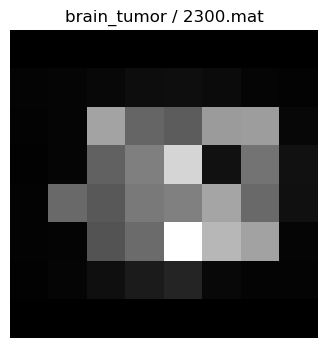


FRQI Quantum Circuit:


┌───┐                                                                 »
q_0: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_1: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_2: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_3: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_4: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_5: ──┤ H ├─────────────────────────────────────────────────────────────────»
     ┌─┴───┴─┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                   »
«q_0: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_1: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_3: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_4: ──────────────────────────────────────────────────────────────»
«                                                                   »
«q_5: ──────────────────────────────────────────────────────────────»
«     ┌──────────────┐┌─────────────┐┌──────────────┐┌─────────────┐»
«q_6: ┤ Ry(0.036255) ├┤ Ry(0.04591) ├┤ Ry(0.066402) ├┤ Ry(0.11507) ├»
«     └──────────────┘└─────────────┘└──────────────┘└─────────────┘»
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_1: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_2: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_3: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_4: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_5: ───────────────────────────────────────────────────────────────»
«     ┌─────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_6: ┤ Ry(0.12256) ├┤ Ry(0.095761) ├┤ Ry(0.047289) ├┤ Ry(0.026994) ├»
«     └─────────────┘└──────────────┘└──────────────┘└──────────────┘»
«                                                                  »
«q_0: ─────────────────────────────────────────────────────────────»
«                                                                  »
«q_1: ─────────────────────────────────────────────────────────────»
«                                                                  »
«q_2: ─────────────────────────────────────────────────────────────»
«                                                                  »
«q_3: ─────────────────────────────────────────────────────────────»
«                                                                  »
«q_4: ─────────────────────────────────────────────────────────────»
«                


FRQI Evaluation:
Qubit Count: 7
Gate Count: 70
Circuit Depth: 64
Gate Fidelity: 0.014085
Data Loss: Yes
Encoding Time (s): 0.0064
Reconstruction Accuracy: Medium
Transformation Supportability: High
Scalability: High
Noise Robustness: Medium
Encoding Time (computed): 0.001732s

NEQR Quantum Circuit:


┌───┐                                                                 »
 q_0: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_1: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_2: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_3: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_4: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤┌───┐                                                            »
 q_6: ┤ X ├┤ X ├────────────────────────────────────────────────────────────»
      ├───┤├───┤┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
 q_7: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤└───┘└───┘└───┘└───┘»
 q_8: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├────────────────────»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤└───┘                    »
 q_9: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─────────────────────────»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤┌───┐┌───┐┌───┐┌───┐┌───┐»
q_10: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_11: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_12: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_13: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                            »
« q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_4: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_5: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_6: ──────────────────────────────────────────────────────────────────────»
«      ┌───┐                                                                 »
« q_7: ┤ X ├─────────────────────────────────────────────────────────────────»
«      └───┘                                                                 »
« q_8: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
« q_9: ──────────────────────────────────────────────────────────────────────»
«      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐                                        »
«q_10: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├────────────────────────────────────────»
«     


NEQR Evaluation:
Qubit Count: 14
Gate Count: 135
Circuit Depth: 31
Gate Fidelity: 0.007353
Data Loss: No
Encoding Time (s): 0.0031
Reconstruction Accuracy: High
Transformation Supportability: Moderate
Scalability: Low
Noise Robustness: Low
Encoding Time (computed): 0.002308s

MCQI Quantum Circuit:


┌───┐                                                                 »
q_0: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_1: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_2: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_3: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_4: ──┤ H ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
q_5: ──┤ H ├─────────────────────────────────────────────────────────────────»
     ┌─┴───┴─┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_5: ────────────────────────────────────────────────────────────────────────»
«     ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
«     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_5: ────────────────────────────────────────────────────────────────────────»
«     ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
«q_6: ┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├┤ Ry(0) ├»
«     └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_1: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_2: ────────────────────────────────────────────────────────


MCQI Evaluation:
Qubit Count: 7
Gate Count: 198
Circuit Depth: 192
Gate Fidelity: 0.005025
Data Loss: Yes
Encoding Time (s): 0.0192
Reconstruction Accuracy: Medium
Transformation Supportability: High
Scalability: High
Noise Robustness: Medium
Encoding Time (computed): 0.004109s
 Error in QL: 'Index 28 out of range for size 6.'
 Error in QPIE: 'Index 6 out of range for size 6.'


In [27]:
from IPython.display import display
import time
import os
import matplotlib.pyplot as plt

dataset_name = "brain_tumor"   # folder name inside datasets
paths = datasets.get(dataset_name, [])

print("\n===============================")
print("Dataset:", dataset_name)

results = []

for path in paths:
    try:
        image = load_image(path)

        # Display image in notebook
        plt.figure(figsize=(4,4))
        plt.imshow(image, cmap='gray')
        plt.title(f"{dataset_name} / {os.path.basename(path)}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(" Error loading image:", e)
        continue

    for name_tech, func in techniques.items():
        try:
            start = time.time()

            circuit = func(image)
            metrics = evaluate(circuit, name_tech)

            results.append({
                "Method": name_tech,
                "Qubits": metrics["Qubit Count"],
                "Gates": metrics["Gate Count"],
                "Depth": metrics["Circuit Depth"]
            })

            elapsed = time.time() - start

            # Display quantum circuit
            print(f"\n{name_tech} Quantum Circuit:")
            display(circuit.draw("text"))


            print(f"\n{name_tech} Evaluation:")
            for k, v in metrics.items():
                print(f"{k}: {v}")

            print(f"Encoding Time (computed): {elapsed:.6f}s")

        except Exception as e:
            print(f" Error in {name_tech}: {e}")


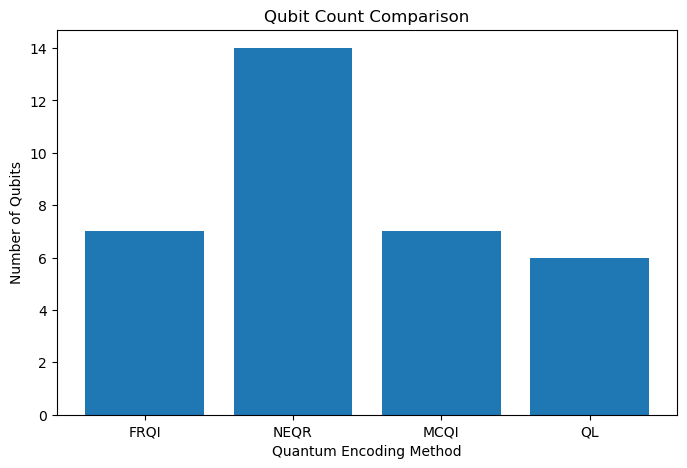

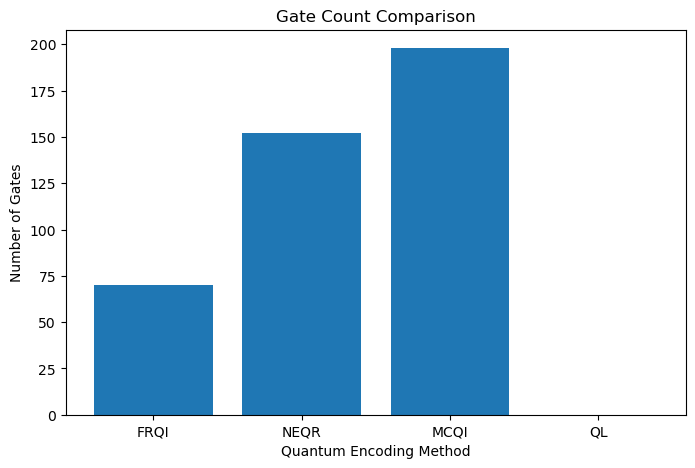

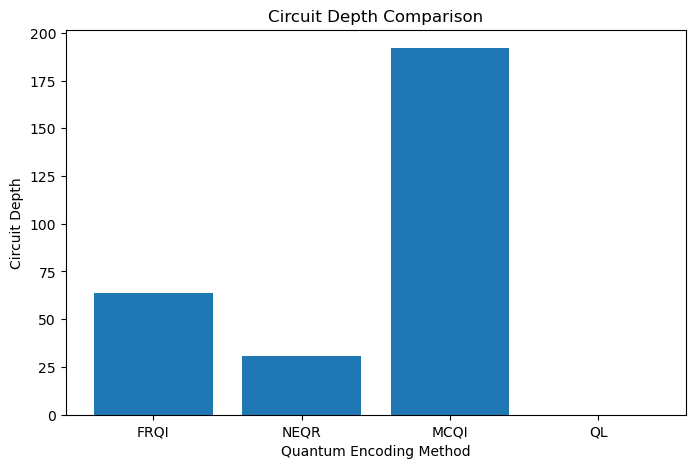

In [28]:
df = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Qubits"])
plt.title("Qubit Count Comparison")
plt.ylabel("Number of Qubits")
plt.xlabel("Quantum Encoding Method")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Gates"])
plt.title("Gate Count Comparison")
plt.ylabel("Number of Gates")
plt.xlabel("Quantum Encoding Method")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Depth"])
plt.title("Circuit Depth Comparison")
plt.ylabel("Circuit Depth")
plt.xlabel("Quantum Encoding Method")
plt.show()
